<a href="https://colab.research.google.com/github/bubblepuzzle/Heritage_Detection_And_Location_Using_CNN/blob/main/MonumentIdentification_main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Import Common Libraries

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
from gensim.models import Word2Vec
import re
import string
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.svm import SVC, NuSVC
from sklearn.multiclass import OneVsRestClassifier, OneVsOneClassifier
from scipy.stats import norm
from sklearn import tree
# Necessary Imports
import cv2
import pathlib
import numpy as np
import pandas as pd
import tensorflow as tf
import os
# View an image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random
from geopy.geocoders import Nominatim
import csv

Mounted at /content/drive


## The Data


In [ ]:
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory
ls = []
import os
for dirname, _, filenames in os.walk('/content/drive/MyDrive/Indian-monuments'):
    for filename in filenames:
        ls.append(os.path.join(dirname, filename))
ls[0]

'/content/drive/MyDrive/Indian-monuments/test/qutub_minar/img22.jpg'

## Runtime Config for GPU

In [ ]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


## The DataSets

In [ ]:
# Path to Kaggle Input
path = "../content/drive/MyDrive/Indian-monuments"
# Walk through the directory and list number of files
for dirpath, dirnames, filenames in os.walk(path):
  print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

There are 3 directories and 0 images in '../content/drive/MyDrive/Indian-monuments'.
There are 24 directories and 0 images in '../content/drive/MyDrive/Indian-monuments/test'.
There are 0 directories and 70 images in '../content/drive/MyDrive/Indian-monuments/test/qutub_minar'.
There are 0 directories and 45 images in '../content/drive/MyDrive/Indian-monuments/test/tanjavur temple'.
There are 0 directories and 62 images in '../content/drive/MyDrive/Indian-monuments/test/tajmahal'.
There are 0 directories and 40 images in '../content/drive/MyDrive/Indian-monuments/test/Sun Temple Konark'.
There are 0 directories and 29 images in '../content/drive/MyDrive/Indian-monuments/test/mysore_palace'.
There are 0 directories and 30 images in '../content/drive/MyDrive/Indian-monuments/test/victoria memorial'.
There are 0 directories and 45 images in '../content/drive/MyDrive/Indian-monuments/test/India_gate'.
There are 0 directories and 100 images in '../content/drive/MyDrive/Indian-monuments/test

##Test and Train Data Paths

In [ ]:
# append the training and the testing paths to the original path
train_dir =  path + "/train/"
test_dir = path + "/test/"
train_dir

'../content/drive/MyDrive/Indian-monuments/train/'

In [ ]:
# get all the class names
data_dir = pathlib.Path(train_dir)
class_names = np.array(sorted([item.name for item in data_dir.glob("*")]))
class_names

array(['Ajanta Caves', 'Charar-E- Sharif', 'Chhota_Imambara',
       'Ellora Caves', 'Fatehpur Sikri', 'Gateway of India',
       'Humayun_s Tomb', 'India gate pics', 'Khajuraho',
       'Sun Temple Konark', 'alai_darwaza', 'alai_minar',
       'basilica_of_bom_jesus', 'charminar', 'golden temple',
       'hawa mahal pics', 'iron_pillar', 'jamali_kamali_tomb',
       'lotus_temple', 'mysore_palace', 'qutub_minar', 'tajmahal',
       'tanjavur temple', 'victoria memorial'], dtype='<U21')

##Define function to draw Random image & Plot loss curves

In [ ]:
# function used to view an random image
def view_random_image(target_dir, target_class):
    target_folder = target_dir  + target_class

  # Get a random image path
    random_image = random.sample(os.listdir(target_folder), 1)

  # Read in the image and plot it using matplotlib
    img = mpimg.imread(target_folder + "/" + random_image[0])
    plt.imshow(img)
    plt.title(target_class)
    plt.axis("off");

    print(f"Image shape: {img.shape}") # show the shape of the image

    return img

def plot_loss_curves(history):
  """
  Returns separate loss curves for training and validation metrics.
  """
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']

  epochs = range(len(history.history['loss']))

  # Plot loss
  plt.plot(epochs, loss, label='training_loss')
  plt.plot(epochs, val_loss, label='val_loss')
  plt.title('Loss')
  plt.xlabel('Epochs')
  plt.legend()

  # Plot accuracy
  plt.figure()
  plt.plot(epochs, accuracy, label='training_accuracy')
  plt.plot(epochs, val_accuracy, label='val_accuracy')
  plt.title('Accuracy')
  plt.xlabel('Epochs')
  plt.legend();

##Display Ramndom Image

Image shape: (302, 167, 3)


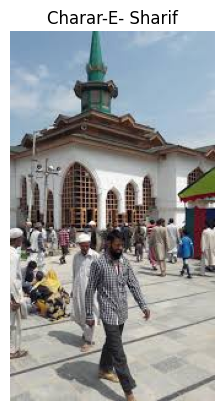

In [ ]:
 #View a random image from the training dataset
import random
img = view_random_image(target_dir=train_dir, target_class=random.choice(class_names)) # get a random class name

##Preprocessing of Data

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, Dense

# Rescale the data and create data generator instances
train_datagen = ImageDataGenerator(rescale=1/255.)
test_datagen = ImageDataGenerator(rescale=1/255.)

# Load data in from directories and turn it into batches
train_data = train_datagen.flow_from_directory(train_dir,
                                               target_size=(300, 300),
                                               batch_size=32,
                                               class_mode='categorical')

test_data = train_datagen.flow_from_directory(test_dir,
                                              target_size=(300, 300),
                                              batch_size=32,
                                              class_mode='categorical')

Found 3691 images belonging to 24 classes.
Found 1054 images belonging to 24 classes.


## Model1 fit

In [ ]:
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, Dense

# # Create our model
#model_1 = Sequential([
#   Conv2D(10, 3, activation='relu', input_shape=(300, 300, 3)),
#   Conv2D(10, 3, activation='relu'),
#   MaxPool2D(),
#   Conv2D(10, 3, activation='relu'),
#   Conv2D(10, 3, activation='relu'),
#   MaxPool2D(),
#   Flatten(),
#   Dense(24, activation='softmax')
#])

# # Compile the model
#model_1.compile(loss="categorical_crossentropy",
#                 optimizer=tf.keras.optimizers.Adam(),
#                 metrics=["accuracy"])

In [ ]:
# # Fit the model
#history_1 = model_1.fit(train_data,
#                         epochs=5,
#                         steps_per_epoch=len(train_data),
#                         validation_data=test_data,
#                         validation_steps=len(test_data))

In [ ]:
#model_1.evaluate(test_data)

In [ ]:
#plot_loss_curves(history_1)

##Model10 (simplified model)

In [ ]:
# Try a simplified model (removed two layers)
model_10 = Sequential([
  Conv2D(10, 3, activation='relu', input_shape=(300, 300, 3)),
  MaxPool2D(),
  Conv2D(10, 3, activation='relu'),
  MaxPool2D(),
  Flatten(),
  Dense(24, activation='softmax')
])

##Fit the model using train data

In [ ]:
model_10.compile(loss='categorical_crossentropy',
                 optimizer=tf.keras.optimizers.Adam(),
                 metrics=['accuracy'])

history_10 = model_10.fit(train_data,
                          epochs=5,
                          steps_per_epoch=len(train_data),
                          validation_data=test_data,
                          validation_steps=len(test_data))

Epoch 1/5
116/116 [==============================] - 1087s 9s/step - loss: 3.3944 - accuracy: 0.1845 - val_loss: 2.9735 - val_accuracy: 0.1983
Epoch 2/5
116/116 [==============================] - 55s 471ms/step - loss: 1.7540 - accuracy: 0.5085 - val_loss: 3.0672 - val_accuracy: 0.3529
Epoch 3/5
116/116 [==============================] - 56s 480ms/step - loss: 0.8682 - accuracy: 0.7678 - val_loss: 3.6789 - val_accuracy: 0.3966
Epoch 4/5
116/116 [==============================] - 56s 483ms/step - loss: 0.3299 - accuracy: 0.9250 - val_loss: 4.2164 - val_accuracy: 0.4051
Epoch 5/5
116/116 [==============================] - 55s 477ms/step - loss: 0.1062 - accuracy: 0.9832 - val_loss: 4.8655 - val_accuracy: 0.4412


## Train loss and validation loss

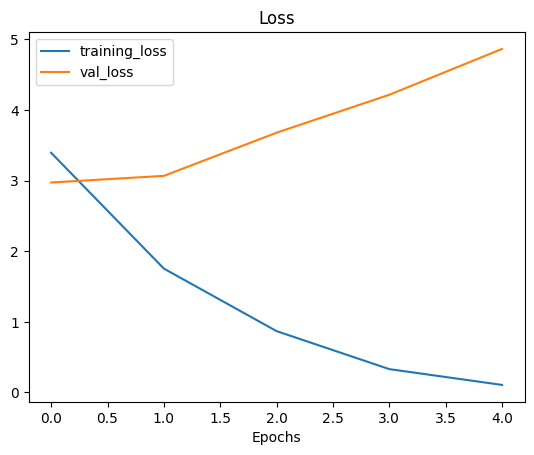

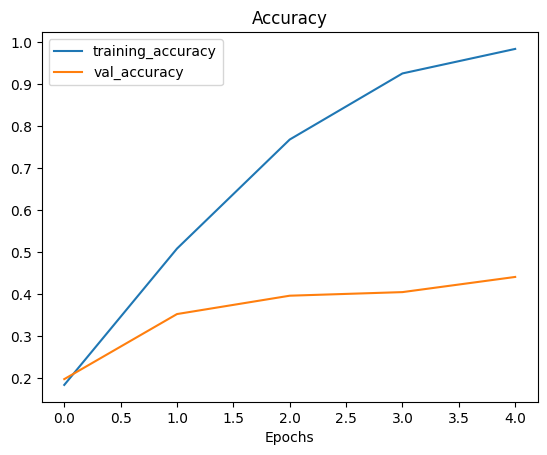

In [ ]:
plot_loss_curves(history_10)

In [ ]:
# train_datagen_augmented = ImageDataGenerator(rescale=1/255.,
#                                              rotation_range=30, # note: this is an int not a float
#                                              width_shift_range=0.3,
#                                              height_shift_range=0.3,
#                                              zoom_range=0.3,
#                                              horizontal_flip=True)

# train_data_augmented = train_datagen_augmented.flow_from_directory(train_dir,
#                                                                   target_size=(300, 300),
#                                                                   batch_size=32,
#                                                                   class_mode='categorical')

In [ ]:
# # Clone the model (use the same architecture)
# model_11 = tf.keras.models.clone_model(model_10)

# # Compile the cloned model (same setup as used for model_10)
# model_11.compile(loss="categorical_crossentropy",
#               optimizer=tf.keras.optimizers.Adam(),
#               metrics=["accuracy"])

# # Fit the model
# history_11 = model_11.fit(train_data_augmented, # use augmented data
#                           epochs=5,
#                           steps_per_epoch=len(train_data_augmented),
#                           validation_data=test_data,
#                           validation_steps=len(test_data))

In [ ]:
# # Check out our model's performance with augmented data
# plot_loss_curves(history_11)

##Prepare image to the target size for pattern matching

In [ ]:
# Create a function to import an image and resize it to be able to be used with our model
def load_and_prep_image(filename, img_shape=300):
  """
  Reads an image from filename, turns it into a tensor
  and reshapes it to (img_shape, img_shape, colour_channel).
  """
  # Read in target file (an image)
  img = tf.io.read_file(filename)

  # Decode the read file into a tensor & ensure 3 colour channels
  # (our model is trained on images with 3 colour channels and sometimes images have 4 colour channels)
  img = tf.image.decode_image(img, channels=3)

  # Resize the image (to the same size our model was trained on)
  img = tf.image.resize(img, size = [img_shape, img_shape])

  # Rescale the image (get all values between 0 and 1)
  img = img/255.

  return img

# Adjust function to work with multi-class
def pred_and_plot(model, filename, class_names):
  """
  Imports an image located at filename, makes a prediction on it with
  a trained model and plots the image with the predicted class as the title.
  """
  # Import the target image and preprocess it
  img = load_and_prep_image(filename)

  # Make a prediction
  pred = model.predict(tf.expand_dims(img, axis=0))

  # Get the predicted class
  if len(pred[0]) > 1: # check for multi-class
    pred_class = class_names[pred.argmax()] # if more than one output, take the max
  else:
    pred_class = class_names[int(tf.round(pred)[0][0])] # if only one output, round

  # Plot the image and predicted class
  plt.imshow(img)
  plt.title(f"Prediction: {pred_class}")
  plt.axis(False);

In [ ]:
def show_monument_Address(monument):
 df = pd.read_csv("/content/drive/MyDrive/Indian-monuments/Location/MonumentLocationInfo.csv")
 # iterate through each row and select
 # 'Name' and 'Longtitude' and 'Latitude' column respectively.
 for ind in df.index:
  if(df['Name'][ind] == monument):
   Lati = df['Latitude'][ind]
   Longi = df['Longitude'][ind]

 # initialize Nominatim API
 geolocator = Nominatim(user_agent= monument)
 location = geolocator.reverse(str(Lati)+","+str(Longi))
 # Display
 print("Address of the monument is: " + str(location))

#show_monument_Address("Chhota") #test the function

##Save the model for subsequent use in practice

In [ ]:
# save the model
model_10.save("saved_trained_model")

## Test: Give test sample images and check the output

1/1 [==============================] - 0s 161ms/step
Address of the monument is: Konark Temple (Sun Temple), NH316, Konark, Puri District, Odisha, 752111, India


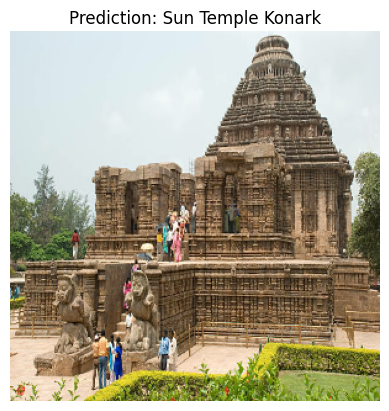

In [ ]:
pred_and_plot(model_10, "../content/drive/MyDrive/Indian-monuments/test/Sun Temple Konark/14.jpg", class_names)
show_monument_Address("Konark")

1/1 [==============================] - 0s 21ms/step
Address of the monument is: Taj Mahal, Taj East Gate Road, Taj Ganj, Agra, Agra District, Uttar Pradesh, 282004, India


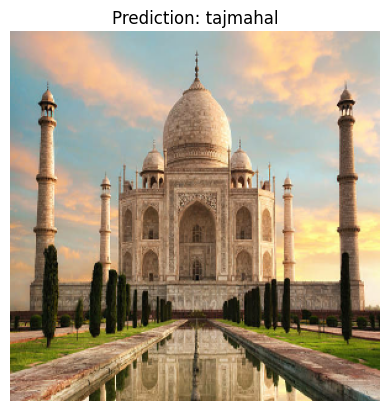

In [ ]:
pred_and_plot(model_10, "../content/drive/MyDrive/Indian-monuments/test/tajmahal/92.jpg", class_names)
show_monument_Address("Tajmahal")

1/1 [==============================] - 0s 20ms/step
Address of the monument is: Humayun's Tomb Complex, Sabz Burj Circle, Defence Colony Tehsil, South East Delhi District, Delhi, 110013, India


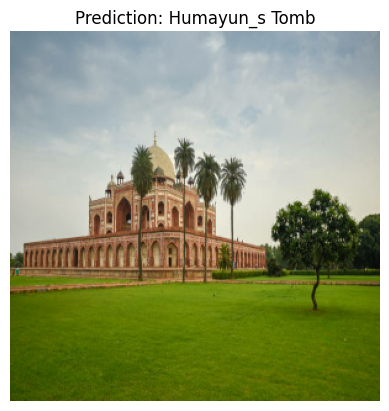

In [ ]:
pred_and_plot(model_10, "../content/drive/MyDrive/Indian-monuments/test/Humayun_s Tomb/25.jpg", class_names)
show_monument_Address("Humayun")

1/1 [==============================] - 0s 20ms/step
Address of the monument is: Qutab Minar, Kalka Das Marg, Mehrauli, Mehrauli Tehsil, South Delhi District, Delhi, 110030, India


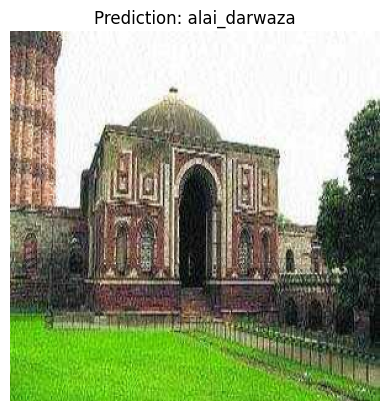

In [ ]:
pred_and_plot(model_10, "../content/drive/MyDrive/Indian-monuments/test/alai_darwaza/img175.jpg", class_names)
show_monument_Address("alaidarwaza")